# Разделимость данных

Примените алгоритмы уменьшения размерности к данным из предыдущей лабораторной, объясните полученные результаты

1. С помощью любого из рассмотренных на лекциях алгоритмов снижения размерности спроецируйте тренировочные данные в 2d пространство. Визуализируйте результаты снижения размерности. Цветом обозначьте категорию объекта
1. Примените алгоритм кластеризации к спроецированным данным. Расчитайте средние внутрикластерное и межкласторное расстояния получившейся проекции
1. Опишите результаты 

In [1]:
import pandas as pd
import numpy as np

start, end = 73000, 90000
names = ['loudness', 'energy', 'danceability']
df = pd.read_csv('data/raw/SpotifyFeatures.csv')[['artist_name', 'track_name', 
                                                  'popularity', 'loudness', 
                                                  'energy', 'danceability']][start:end]
def to_status(num):
    if 0 <= num and num <= 10:
        return 3
    if 11 <= num and num <= 20:
        return 2
    if 21 <= num and num <= 80:
        return 1
    return 0

df['status'] = df['popularity'].apply(to_status)
df.head(5)

,artist_name,track_name,popularity,loudness,energy,danceability,status
73000,Sugar Kane Music,Little Peter Rabbit,9,-10.820,0.359,0.951,3
73001,Sugar Kane Music,Dr Knickerbocker,11,-9.269,0.710,0.864,2
73002,The Hit Crew Kids,Ghostbusters,4,-6.223,0.717,0.758,3
73003,The Hit Crew Kids,Monster Mash,5,-6.727,0.787,0.791,3
73004,The Hit Crew Kids,Addams Family Theme,5,-13.034,0.310,0.635,3


In [2]:
a, b, c, d, i, count = 0, 0, 0, 0, 0, 150
res, category = [], []

data = np.array(df[names])
dataCategory = np.array(df['status'])

def push_category(i, cat, t):
    if (dataCategory[i] == cat and t < count):
        res.append(data[i])
        category.append(dataCategory[i])
        return t + 1
    return t

while (a < count or b < count or c < count):
    a = push_category(i, 0, a)
    b = push_category(i, 1, b)
    c = push_category(i, 2, c)
    d = push_category(i, 3, d)
    i += 1

# Уменьшение размерности
## Извлечение признаков

### Анализ главных компонентов (PCA)

#### Алгоритм PCA
1. Определить $k<n$ - новую размерность
2. Вычесть из $X$ среднее, то есть заменить все $\Large x^{(i)}$  на $$\Large  x^{(i)} - \frac{1}{m} \sum_{i=1}^{m}{x^{(i)}}$$
3. Привести данные к единичной дисперсии: посчитать $$\Large  \sigma_j^2 = \frac{1}{m} \sum_{i=1}^{m}{(x^{(i)})^2}$$
и заменить $\Large x_j^{(i)}$ на $\Large \frac{x_j^{(i)}}{\sigma_j}$ 
4. Найти сингулярное разложение матрицы $X$:
$$\Large X = UDV^T$$
5. Положить $V =$ [$k$ левых столбцов матрицы $V$]
6. Вернуть новую матрицу $$\Large Z = XV \in \mathbb{R}^{m \times k}$$

In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


Meaning of the 2 components:
-0.999 x loudness + -0.036 x energy + -0.016 x danceability
0.012 x loudness + 0.128 x energy + -0.992 x danceability


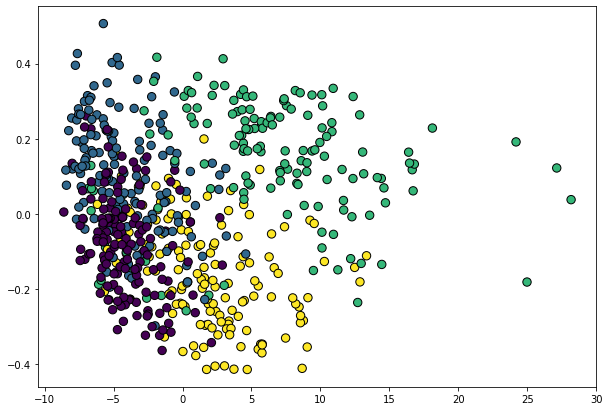

In [4]:
#from sklearn import datasets

#iris = datasets.load_iris()
#X, y = iris.data, iris.target
X, y = np.array(res), category

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component, names)))
plt.figure(figsize=(10,7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=70, edgecolor="k")
plt.show()

# Кластеризация, алгоритм k-средних

1. Выбрать $k$ точек (центроидов) $\{c_i\}_{i=1}^k$ из набора данных.
2. **Повторять**
    + Для каждого 𝑥 найти ближайший центроид $n(x).$ 
$$C_i = {x | n(x)=c_i}$$              
    + Для каждого $C_i$ найти центральную точку и определить её центроидом. 
3. **Пока** центроиды не будут изменяться.

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # for plot styling
import numpy as np

Text(0.98, 0.98, 'Final Clustering')

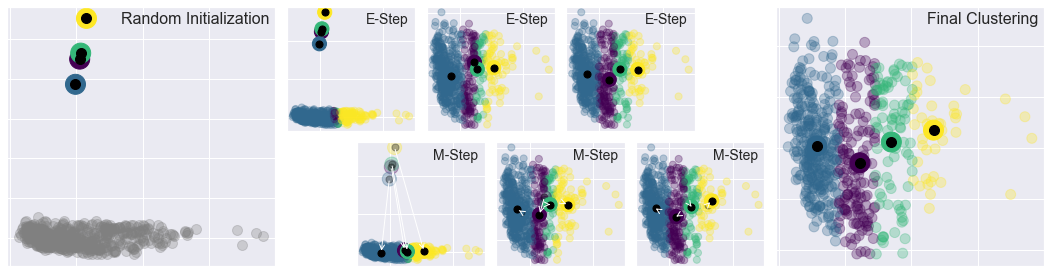

In [6]:
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances_argmin

X, y_true = X_reduced, y

rng = np.random.RandomState(42)
centers = [0, 4] + rng.randn(4, 1)

def draw_points(ax, c, factor=1):
    ax.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis',
               s=50 * factor, alpha=0.3)
    
def draw_centers(ax, centers, factor=1, alpha=1.0):
    ax.scatter(centers[:, 0], centers[:, 1],
               c=np.arange(4), cmap='viridis', s=200 * factor,
               alpha=alpha)
    ax.scatter(centers[:, 0], centers[:, 1],
               c='black', s=50 * factor, alpha=alpha)

def make_ax(fig, gs):
    ax = fig.add_subplot(gs)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    return ax

fig = plt.figure(figsize=(15, 4))
gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
ax0 = make_ax(fig, gs[:4, :4])
ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
         ha='right', va='top', size=16)
draw_points(ax0, 'gray', factor=2)
draw_centers(ax0, centers, factor=2)

for i in range(3):
    ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
    ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])
    
    # E-step
    y_pred = pairwise_distances_argmin(X, centers)
    draw_points(ax1, y_pred)
    draw_centers(ax1, centers)
    
    # M-step
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
    draw_points(ax2, y_pred)
    draw_centers(ax2, centers, alpha=0.3)
    draw_centers(ax2, new_centers)
    for i in range(4):
        ax2.annotate('', new_centers[i], centers[i],
                     arrowprops=dict(arrowstyle='->', linewidth=1))
        
    
    # Finish iteration
    centers = new_centers
    ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
    ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)


# Final E-step    
y_pred = pairwise_distances_argmin(X, centers)
axf = make_ax(fig, gs[:4, -4:])
draw_points(axf, y_pred, factor=2)
draw_centers(axf, centers, factor=2)
axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
         ha='right', va='top', size=16)


In [7]:
from sklearn.metrics.pairwise import euclidean_distances

dists = euclidean_distances(centers)[np.triu_indices(4, 1)]

print(dists.max(), dists.mean(), dists.min())

17.635977401100888 9.611101086263742 4.757651650527332


In [8]:
from math import sqrt

def calcDist(sign):
    def dist(p1, p2):
        return sqrt(((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2))

    avgDist, k = 0, 0
    for i in range(1, len(y_pred)):
        for j in range(0, i):
            if eval(str(y_pred[i]) + sign + str(y_pred[j])):
                avgDist += (dist(X[i], X[j]))
                k += 1
    return avgDist / k

print('Среднее внутрикластерное расстояние', calcDist("=="))
print('Среднее межкластерное расстояние', calcDist("!="))

Среднее внутрикластерное расстояние 2.1584936227588827
Среднее межкластерное расстояние 9.322158726649285
